The measurement of the muon transverse momentum of muons is sensitive to several detector conditions:
   * the *alignment* of the tracker and of the muon chambers
   * the *composition and distribution of the material* inside the tracking volume
   * the knowledge of the *magnetic field* inside and outside the solenoid volume.
<br>

All these conditions affect differently the momentum measurement and can produce biases. In particular, the detector misalignment produces a relative bias that generally increases linearly with the momentum. For this reason it is extremely important to have an accurate knowledge of the tracker and muon spectrometer alignment, and a detailed mapping of the detector material and of the magnetic field. Residual biases can be corrected *a posteriori*, using calibration techniques that generally exploit data from very well-known processes, such as J/&psi;&rarr;&mu;&mu; or Z&rarr;&mu;&mu; decays.

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import ROOT

Welcome to JupyROOT 6.30/02


In [2]:
events = NanoEventsFactory.from_root(
    "/eos/uscms/store/user/cmsdas/2025/short_exercises/muons/DYJets.root", 
    schemaclass=NanoAODSchema,
    treepath = "Events",
).events()

In [4]:
muon=events.Muon

First check the available fields for muon arrays

In [14]:
muon.fields

['dxy',
 'dxyErr',
 'dxybs',
 'dz',
 'dzErr',
 'eta',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'mvaMuID',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'pfRelIso04_all',
 'phi',
 'pt',
 'ptErr',
 'segmentComp',
 'sip3d',
 'softMva',
 'tkRelIso',
 'tunepRelPt',
 'mvaLowPt',
 'mvaTTH',
 'charge',
 'jetIdx',
 'nStations',
 'nTrackerLayers',
 'pdgId',
 'svIdx',
 'tightCharge',
 'fsrPhotonIdx',
 'highPtId',
 'highPurity',
 'inTimeMuon',
 'isGlobal',
 'isPFcand',
 'isStandalone',
 'isTracker',
 'jetNDauCharged',
 'looseId',
 'mediumId',
 'mediumPromptId',
 'miniIsoId',
 'multiIsoId',
 'mvaId',
 'mvaLowPtId',
 'mvaMuID_WP',
 'pfIsoId',
 'puppiIsoId',
 'softId',
 'softMvaId',
 'tightId',
 'tkIsoId',
 'triggerIdLoose',
 'genPartIdx',
 'genPartFlav',
 'fsrPhotonIdxG',
 'genPartIdxG',
 'jetIdxG']

# Step 1: Generated and reconstructed dimuon Z mass
First, lets reconstruct dimuon z mass.
reapplying previous code. Using the following criteria to select two well-defined and isolated muons. For instance, you can require that both muons pass:<br>

* Muon_genPartIdx!=-1(each muon must have an associated generated particle)
* Muon_isGlobal==1
* Muon_pt>20.
* abs(Muon_eta)<2.4
* Muon_pfRelIso03_chg<0.15

In [17]:
muon_mask=(muon.genPartIdx!=-1)& (muon.isGlobal==1)& (muon.pt>20)& (abs(muon.eta)<2.4)& (muon.pfRelIso03_chg<0.15)

In [18]:
muons_good=muon[muon_mask]

We only keep events with 2 good muons. There are 6 events with over 2 muons, we will ignore them for simplicity.

In [19]:
two_good_muons=muons_good[ak.num(muons_good)==2]

In [20]:
two_good_muons.charge

<Array [[1, -1], [-1, 1], ... [-1, 1], [1, -1]] type='2429 * var * int32[paramet...'>

Lets make sure muons in eaach events have opposite charge

In [21]:
opposite_sign_muon_mask=(two_good_muons.charge[:,0]!=two_good_muons.charge[:,1])

In [22]:
two_opposite_good_muons=two_good_muons[opposite_sign_muon_mask]

In [23]:
dimuon_p4 = (two_opposite_good_muons[:, 0] + two_opposite_good_muons[:, 1])

In [24]:
print(dimuon_p4.mass)

[91.8, 88.2, 89.2, 90.4, 86.8, 84.8, 94.4, ... 71.9, 81.3, 74.5, 95, 89.5, 91.1]


### Fill in the code below to create a mask to require the invariant mass to be between 70 and 110 GeV

In [27]:
dimuon_mass_mask = 

Text(0, 0.5, 'Events')

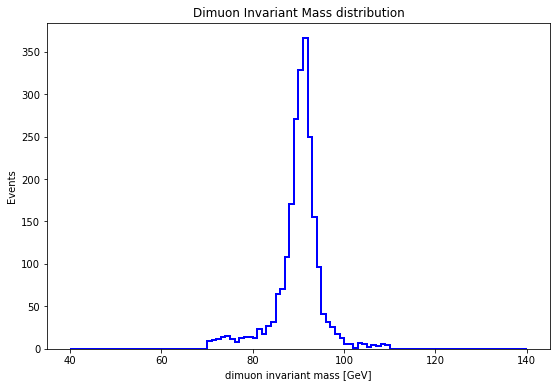

In [28]:
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4.mass[dimuon_mass_mask], bins=100, range=[40,140], histtype='step',linewidth=2, color='blue', label='dimuon invariant mass')
plt.title('Dimuon Invariant Mass distribution')
plt.xlabel('dimuon invariant mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

In [34]:
gen_muon=two_opposite_good_muons.matched_gen

### Fill in the code below to generator di-muon array by summing the two muons in each event, using the same format as the reconstructed di-muon system `dimuon-p4` above

In [35]:
gen_dimuon_p4=

print(gen_dimuon_p4.mass)

[96, 87.2, 89.3, 90.4, 86.6, 89.9, 93.2, ... 60.6, 72.4, 81.7, 74.3, 94.4, 89, 91.1]


Text(0, 0.5, 'Events')

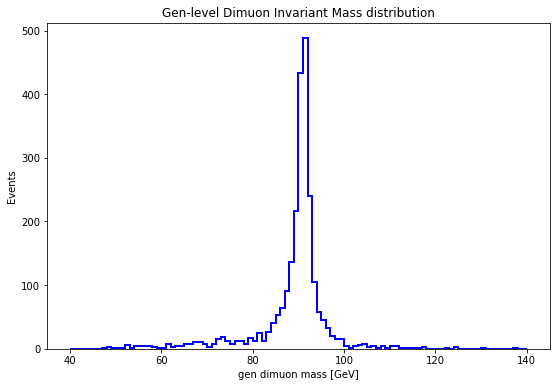

In [36]:
plt.figure(figsize=(9,6))
plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', linewidth=2, color='blue', label='gen dimuon_mass')
plt.title('Gen-level Dimuon Invariant Mass distribution')
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

Then, we fit both generated and reconstructed Z mass.<br>
Keep in mind that the Z line shape is not Gaussian, so the Gaussian fit might not be perfect. We then fit them with more suitable functions for each case, e.g. a Breit-Wigner function for the generated mass and a Voigt function (i.e. a convolution of a Breit-Wigner with a Gaussian) for the reconstructed mass. You can easily do this from the ROOT e.g.:

Fit the generator-level mass first:

In [51]:
c1 = ROOT.TCanvas("gendimuonmass","",900,600)
h_GenDiMuonM = ROOT.TH1F("h_GenDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in gen_dimuon_p4.mass:
    h_GenDiMuonM.Fill(m)
h_GenDiMuonM.Draw()
c1.Draw()
f2 = ROOT.TF1("f2", "[0]*TMath::BreitWigner(x, [1], [2])", 86., 96.)
f2.SetParameter(1, 91.1876)
f2.SetParameter(2, 2.4952)
h_GenDiMuonM.Fit("f2", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c1.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      34.0254
NDf                       =           17
Edm                       =  5.48893e-06
NCalls                    =           86
p0                        =      1110.58   +/-   27.2907     
p1                        =        91.02   +/-   0.0414227   
p2                        =      2.72766   +/-   0.110309    


Warning in <TCanvas::Constructor>: Deleting canvas with same name: gendimuonmass
Warning in <TROOT::Append>: Replacing existing TH1: h_GenDiMuonM (Potential memory leak).


Then fit the reconstructed di-muon mass, fill in the code below to first create a reconstructed di-muon mass histogram

Warning in <TCanvas::Constructor>: Deleting canvas with same name: recdimuonmass
Warning in <TROOT::Append>: Replacing existing TH1: h_RecDiMuonM (Potential memory leak).


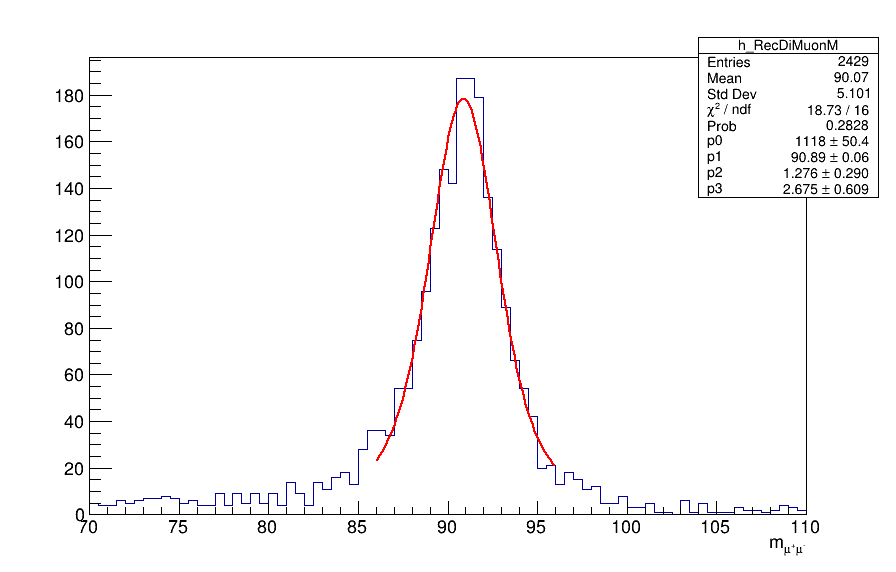

In [43]:
c2 = ROOT.TCanvas("recdimuonmass","",900,600)
h_RecDiMuonM = ROOT.TH1F("h_RecDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)

###########################
## Fill the histogram content here
###########################

h_RecDiMuonM.Draw()
c2.Draw()


Now fit the histogram!

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      18.7316
NDf                       =           16
Edm                       =  1.65441e-07
NCalls                    =          167
p0                        =      1118.09   +/-   50.4008     
p1                        =      90.8937   +/-   0.0612916   
p2                        =      1.27577   +/-   0.290253    
p3                        =       2.6749   +/-   0.608651    


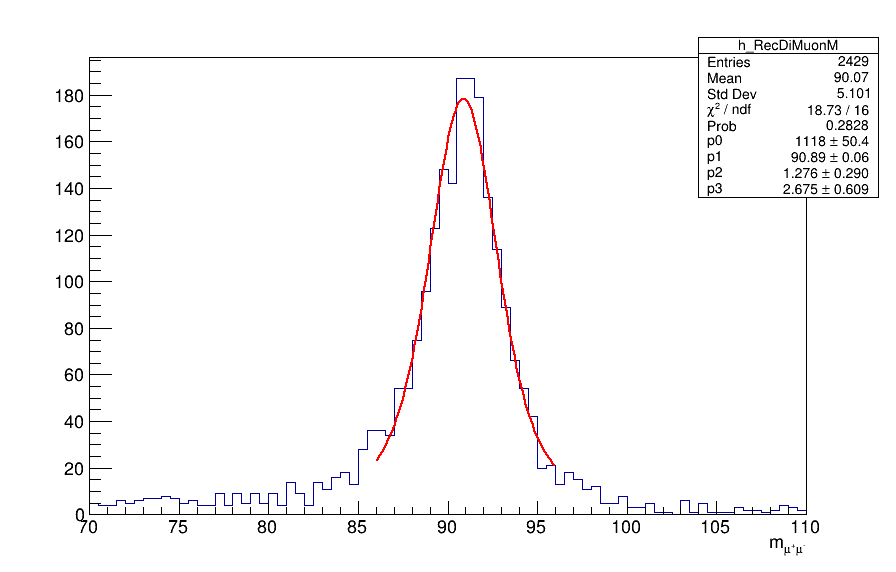

In [54]:
f1 = ROOT.TF1("f1", "[0]*TMath::Voigt(x-[1], [2], [3])", 86., 96.)
f1.SetParameter(1, 91.1876)
f1.SetParameter(3, 2.4952)
h_RecDiMuonM.Fit("f1", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c2.Draw()


**Questions 1:**
   * Compare the mean values obtained from the fits to the generated and reconstructed distributions. Are they compatible or do they differ significantly? How do they compare to the nominal Z mass value, m<sub>Z</sub> = 91.1876 GeV? Which distribution has the larger shift with respect to m<sub>Z</sub>?
   * Compare the widths of the two distributions (GEN and RECO). Which one is larger? Can you explain why? 
   * Considering that the natural width of the Z boson is &Gamma;<sub>Z</sub> = 2.4952 GeV, can you roughly estimate the typical dimuon mass resolution of Z&rarr;&mu;&mu; events measured with the CMS detector?(*Note:* with a _Voigtian_ fit, you would get an estimate of the  mass resolution directly from the fit) 
   * Why do you need different functions to better fit the generated and reconstructed mass distributions? What differs between the two? If you had to fit the peak of a reconstructed J/&psi; instead, what function would you use, and why?



# Step 2: Investigate the muon transverse momentum resolution

Now we will study the muon transverse momentum resolution. We will consider distributions of the transverse momentum residuals, defined as  R(1/pT) = (1/pT<sup>REC</sup> &ndash; 1/pT<sup>GEN</sup>)/(1/pT<sup>GEN</sup>). In the ideal case, the distribution of the residuals is expected to be Gaussian and its standard deviation is the pT resolution. Likewise, we can define the dimuon invariant mass residuals as R(M) = (M<sup>REC</sup> &ndash; M<sup>GEN</sup>)/M<sup>GEN</sup>, and the standard deviation of the R(M) distribution defines the mass resolution. 

We will first study R(1/PT):
   * 1D histogram of the muon transverse momentum residuals R(1/PT): A histogram (h_MupTRes) of the muon transverse momentum residual using the PAT muons and GEN muons. 
   * Fit this distribution to a Gaussian function. 
   * The fit parameter sigma gives the muon transverse momentum resolution in the chosen p<sub>T</sub> range.

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      222.177
NDf                       =           47
Edm                       =  2.42623e-06
NCalls                    =           60
Constant                  =      580.239   +/-   12.2074     
Mean                      =  0.000325455   +/-   0.000234163 
Sigma                     =    0.0159232   +/-   0.000239693  	 (limited)


Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResu

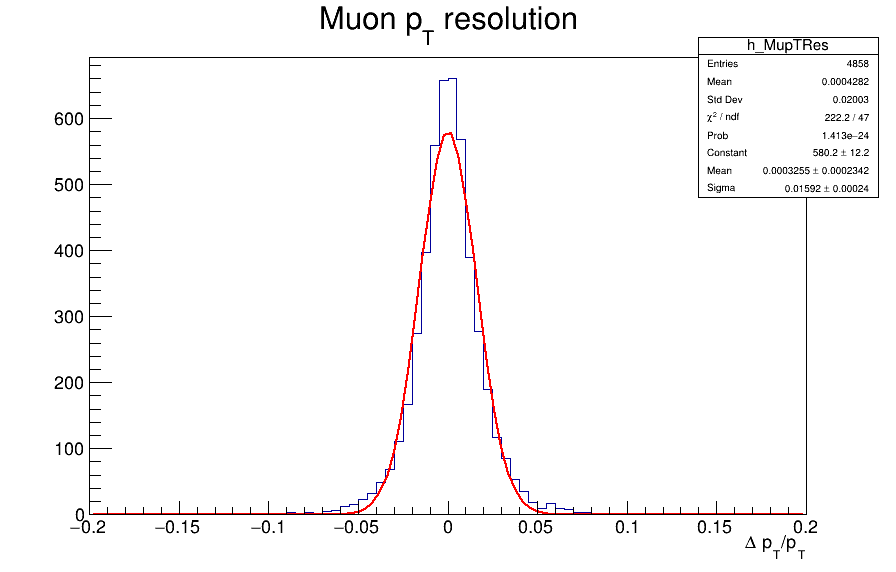

In [57]:
pt_res=ak.flatten(two_opposite_good_muons.matched_gen.pt)/ak.flatten(two_opposite_good_muons.pt)-1

c6 = ROOT.TCanvas("ptresidual","",900,600)
h_MupTRes = ROOT.TH1F("h_MupTRes","Muon p_{T} resolution;#Delta p_{T}/p_{T};",80,-0.2,0.2)
for res in pt_res:
    h_MupTRes.Fill(res)
h_MupTRes.Draw()
c6.Draw()
h_MupTRes.Fit("gaus")



Let's now study the dimuon invariant mass residual R(M), with a similar procedure as above:
  * Make a 1D histogram of the dimuon invariant mass residuals R(M): A histogram (h_MassRes) for the invariant mass resolution residual, which is defined as (M<sub>rec</sub> - M<sub>gen</sub> )/M<sub>gen</sub>. 
  * Fit this distribution to a Gaussian.
    
### Fill in the code below to plot and fit the distribution
* define R(M) as a variable called `mass_res`
* add a line in for loop to fill the histogram
* add a line at the end of the cell to fit the distribution to a Gaussian

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      96.3393
NDf                       =           39
Edm                       =  2.12586e-06
NCalls                    =           64
Constant                  =      295.845   +/-   8.43226     
Mean                      = -0.000203883   +/-   0.000244138 
Sigma                     =    0.0117855   +/-   0.000230695  	 (limited)


Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResu

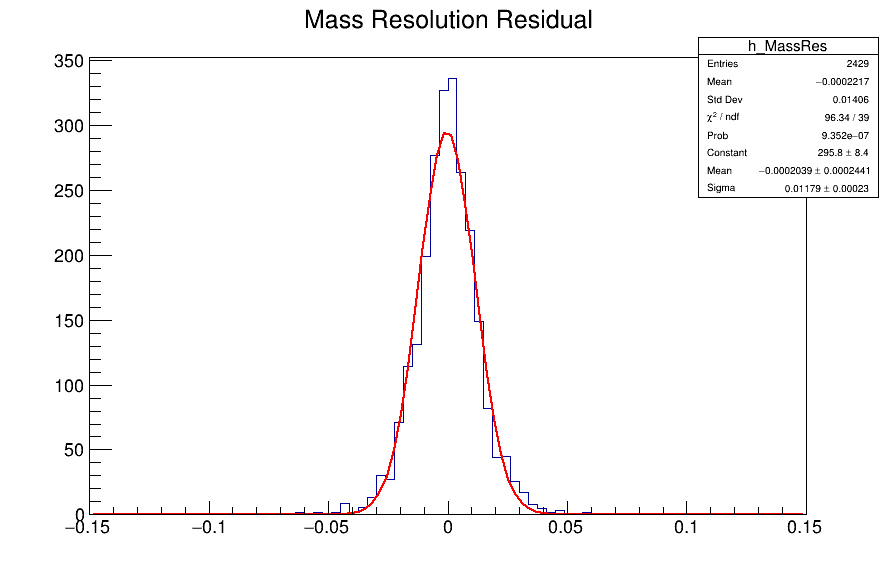

In [58]:
mass_res=

c7 = ROOT.TCanvas("massresidual","",900,600)
h_MassRes = ROOT.TH1F("h_MassRes","Mass Resolution Residual",80,-0.15,0.15)
for res in mass_res:
    ### fill histogram here
    
h_MassRes.Draw()
c7.Draw()
# add a line here to fit the histogram

We will make a [TProfile histograms](http://root.cern.ch/root/html/TProfile.html) (prof_MupTvspTRes and prof_MuEtavspTRes) of muon transverse momentum residuals  as a function of muon pT and &eta;.
Note that, by default, a [TProfile](http://root.cern.ch/root/html/TProfile.html) will display in each bin the <span style='color:red'> mean value $\pm$ mean value error </span> (i.e. RMS/$\sqrt(N)$). Initializing the [TProfile](http://root.cern.ch/root/html/TProfile.html)  with option "s" instead, it will display <span style='color:red'> mean value $\pm$ RMS </span>. This is more useful for us, as the RMS estimates the standard deviation, i.e. the resolution of each bin. 

Let's first plot the muon pT residual as a function of eta:

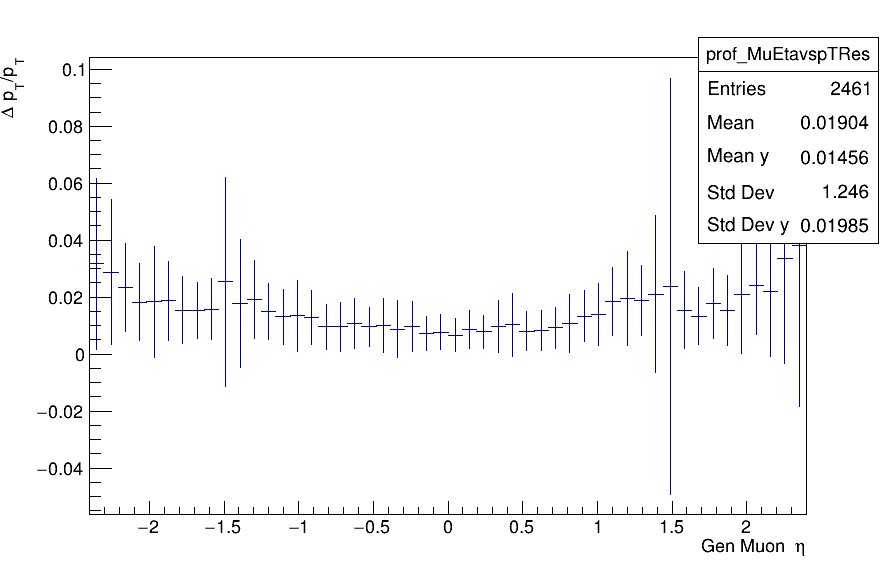

In [60]:
prof_MuEtavspTRes = ROOT.TProfile("prof_MuEtavspTRes",";Gen Muon #eta;#Delta p_{T}/p_{T}",50,-2.4,2.4,0,1,'s')
for ptres, eta in zip(pt_res, ak.flatten(two_opposite_good_muons.matched_gen.eta)):
    prof_MuEtavspTRes.Fill(eta, ptres, 1)
c8 = ROOT.TCanvas("muetavsptres","",900,600)
prof_MuEtavspTRes.Draw()
c8.Draw()

Now can you plot the muon pT residual as a function of pT?

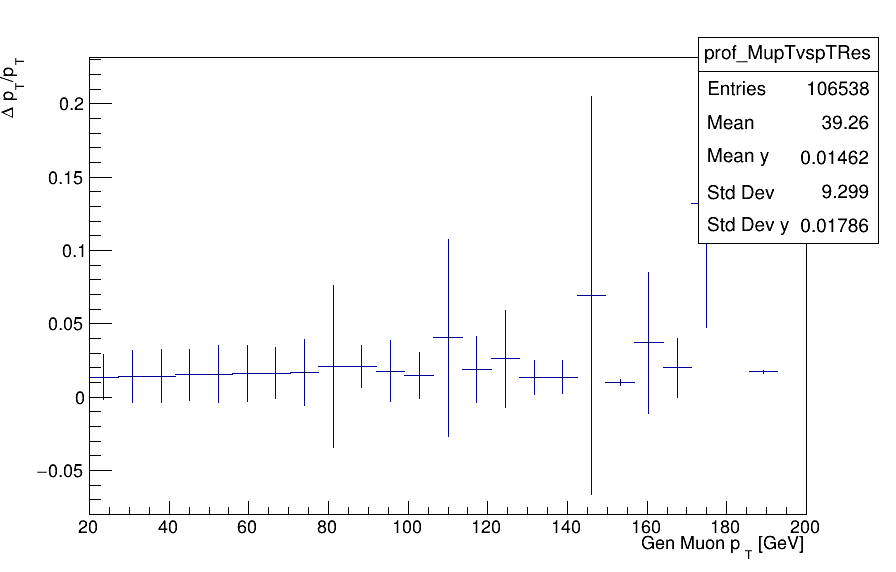

In [71]:
prof_MupTvspTRes = 

c9 = ROOT.TCanvas("muptvsptres","",900,600)
prof_MupTvspTRes.Draw()
c9.Draw()

**Questions 2**:
* What is the typical 1/pT resolution of a 50 GeV muon measured in the CMS detector?
* How does the 1/pT resolution scale with transverse momentum? And with the pseudorapidity?
* Why is the mass residual not a perfect Gaussian distribution?
* How is the 1/pT resolution related to the invariant mass resolution?

# Step 3: Momentum scale corrections

As mentioned in the introduction, small biases in the muon momentum measurement can be recovered by applying specific corrections. In CMS we have several algorithms to compute such corrections to the momentum scale and/or resolution. They are documented in this MUO POG [TWiki page](https://twiki.cern.ch/twiki/bin/view/CMS/MuonReferenceScaleResolRun2). In the following, we will demonstrate the use of one of these correction strategies, called _Rochester algorithm_. The details of the algorithm and how it computes the corrections are beyond the goals of this exercise. Suffice it to say that it extracts correction factors by "forcing" muons from (mostly) Z&rarr;&mu;&mu; decays to coincide with reference distributions obtained from Monte Carlo generated muons. For more details, check out  [EPJC V72, 10.2194 (2012)](https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-012-2194-8) [arXiv:1208.3710](https://arxiv.org/abs/1208.3710) or the link above.


Since Run 3, the corrections are provided in JSON format that can be read with the correctionlib package. Code to calculate the corrected pT vaues for invidivual muons based on these corrections is also provided by Muon POG on [gitlab](https://gitlab.cern.ch/cms-muonPOG/muonscarekit/-/tree/master?ref_type=heads). This will be moved to central repositories maintained by CAT and XPOG in the future.  

In [61]:
from MuonScaRe import pt_resol, pt_scale
import correctionlib

In [62]:
cset = correctionlib.CorrectionSet.from_file("2022_schemaV2.json")

print (cset.get("cb_params").evaluate(1.3, 8., 0))

#For MC, we need to apply both scale and resolution correction. We apply scale corrections first
two_opposite_good_muons["pt_scalecorr"] = pt_scale(0, two_opposite_good_muons.pt, two_opposite_good_muons.eta, two_opposite_good_muons.phi, two_opposite_good_muons.charge, "nom", cset)
#Next, we apply resolution corrections using the scale-corrected pT values as input
two_opposite_good_muons["pt_fullcorr"] = pt_resol(two_opposite_good_muons.pt_scalecorr, two_opposite_good_muons.eta, two_opposite_good_muons.nTrackerLayers, "nom", cset)

0.011189300393776816


In [64]:
from coffea.nanoevents.methods import candidate
muonCorrected = ak.zip({
            "pt": two_opposite_good_muons.pt_fullcorr,
            "eta": two_opposite_good_muons.eta,
            "phi": two_opposite_good_muons.phi,
            "mass": two_opposite_good_muons.mass,
            "charge": two_opposite_good_muons.charge,
            "isolation": two_opposite_good_muons.pfRelIso03_all,
        }, with_name="PtEtaPhiMCandidate", behavior=candidate.behavior)


In [65]:
dimuon_p4_corr=muonCorrected[:,0]+muonCorrected[:,1]

In [66]:
dimuon_mass_mask=(dimuon_p4_corr.mass>70)&(dimuon_p4_corr.mass<110)

Text(0, 0.5, 'Events')

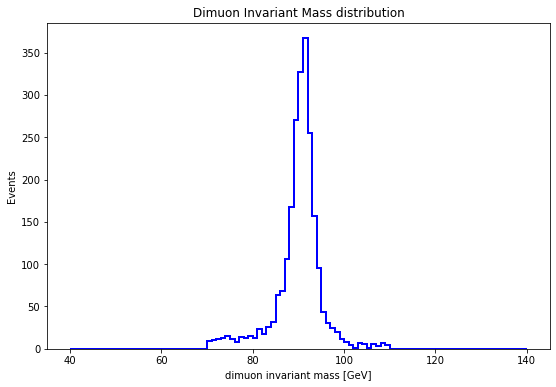

In [67]:
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4_corr.mass[dimuon_mass_mask], bins=100, range=[40,140], histtype='step',linewidth=2, color='blue', label='dimuon invariant mass')
plt.title('Dimuon Invariant Mass distribution')
plt.xlabel('dimuon invariant mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

Text(0, 0.5, 'Events')

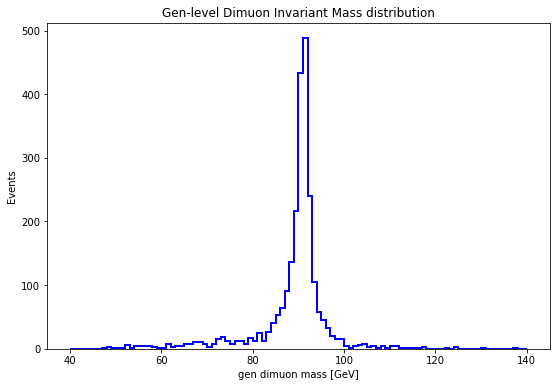

In [68]:
plt.figure(figsize=(9,6))
plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', linewidth=2, color='blue', label='gen dimuon_mass')
#plt.legend()
plt.title('Gen-level Dimuon Invariant Mass distribution')
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

In [69]:
c10 = ROOT.TCanvas("gendimuonmass","",900,600)
h_GenDiMuonM = ROOT.TH1F("h_GenDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in gen_dimuon_p4.mass:
    h_GenDiMuonM.Fill(m)
h_GenDiMuonM.Draw()
c10.Draw()
f2 = ROOT.TF1("f2", "[0]*TMath::BreitWigner(x, [1], [2])", 86., 96.)
f2.SetParameter(1, 91.1876)
f2.SetParameter(2, 2.4952)
h_GenDiMuonM.Fit("f2", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c10.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      34.0254
NDf                       =           17
Edm                       =  5.48893e-06
NCalls                    =           86
p0                        =      1110.58   +/-   27.2907     
p1                        =        91.02   +/-   0.0414227   
p2                        =      2.72766   +/-   0.110309    


Warning in <TCanvas::Constructor>: Deleting canvas with same name: gendimuonmass
Warning in <TROOT::Append>: Replacing existing TH1: h_GenDiMuonM (Potential memory leak).


In [70]:
c11 = ROOT.TCanvas("recdimuonmass","",900,600)
h_RecDiMuonM = ROOT.TH1F("h_RecDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in dimuon_p4_corr.mass:
    h_RecDiMuonM.Fill(m)
h_RecDiMuonM.Draw()
c11.Draw()
f1 = ROOT.TF1("f1", "[0]*TMath::Voigt(x-[1], [2], [3])", 86., 96.)
f1.SetParameter(1, 91.1876)
f1.SetParameter(3, 2.4952)
h_RecDiMuonM.Fit("f1", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c11.Draw()
#h_RecDiMuonM.Fit("gaus","","", 86., 96.)

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      18.4458
NDf                       =           16
Edm                       =  1.64965e-08
NCalls                    =          185
p0                        =      1132.71   +/-   49.2919     
p1                        =      90.9358   +/-   0.0610893   
p2                        =      1.17714   +/-   0.297462    
p3                        =      2.88007   +/-   0.584644    


Warning in <TCanvas::Constructor>: Deleting canvas with same name: recdimuonmass
Warning in <TROOT::Append>: Replacing existing TH1: h_RecDiMuonM (Potential memory leak).


Text(0, 0.5, 'Events')

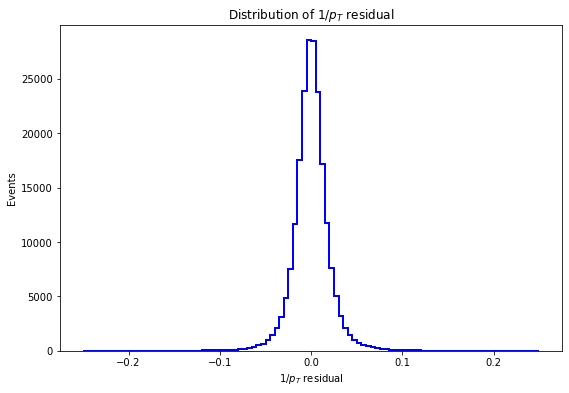

In [97]:
pt_res=ak.flatten(two_opposite_good_muons.matched_gen.pt)/ak.flatten(two_opposite_good_muons.pt_fullcorr)-1
plt.figure(figsize=(9,6))
plt.hist(pt_res, bins=100, range=[-0.25,0.25], histtype='step',linewidth=2, color='blue', label='$1/p_T$ residual')
#plt.legend()
plt.title('Distribution of $1/p_T$ residual')
plt.xlabel('$1/p_T$ residual')
plt.ylabel('Events')

In [98]:
mass_res=dimuon_p4_corr.mass/gen_dimuon_p4.mass-1

Text(0, 0.5, 'Events')

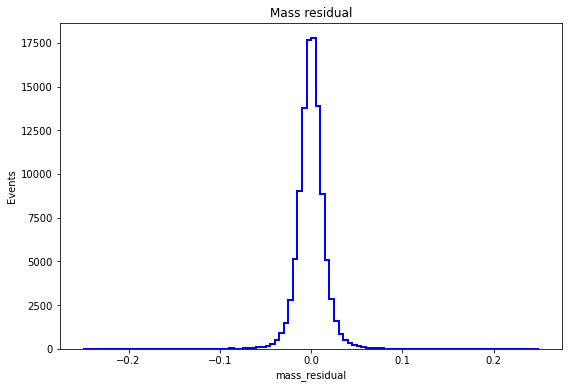

In [99]:
plt.figure(figsize=(9,6))
plt.hist(mass_res, bins=100, range=[-0.25,0.25], histtype='step', linewidth=2, color='blue', label='mass_residual')
#plt.legend()
plt.title('Mass residual')
plt.xlabel('mass_residual')
plt.ylabel('Events')

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      10236.4
NDf                       =           77
Edm                       =  1.18788e-07
NCalls                    =           71
Constant                  =      25048.4   +/-   80.6984     
Mean                      =  4.07957e-05   +/-   3.55266e-05 
Sigma                     =    0.0158457   +/-   3.66537e-05  	 (limited)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: ptresidual
Warning in <TROOT::Append>: Replacing existing TH1: h_MupTRes (Potential memory leak).
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error i

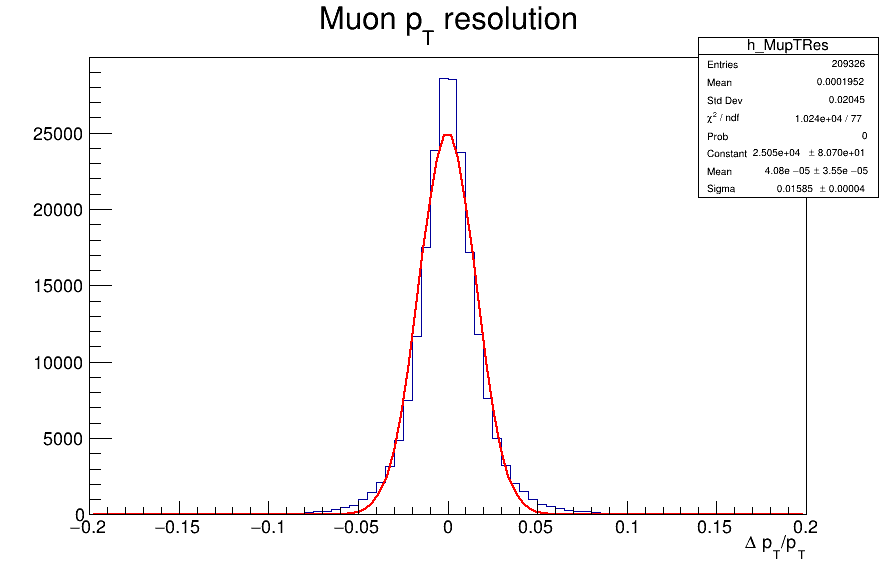

In [100]:
c16 = ROOT.TCanvas("ptresidual","",900,600)
h_MupTRes = ROOT.TH1F("h_MupTRes","Muon p_{T} resolution;#Delta p_{T}/p_{T};",80,-0.2,0.2)
for res in pt_res:
    h_MupTRes.Fill(res)
h_MupTRes.Draw()
c16.Draw()
h_MupTRes.Fit("gaus")

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      3510.56
NDf                       =           75
Edm                       =  4.72918e-06
NCalls                    =           67
Constant                  =      12334.6   +/-   53.7852     
Mean                      = -8.99469e-06   +/-   3.85724e-05 
Sigma                     =    0.0122642   +/-   3.70371e-05  	 (limited)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: massresidual
Warning in <TROOT::Append>: Replacing existing TH1: h_MassRes (Potential memory leak).
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error

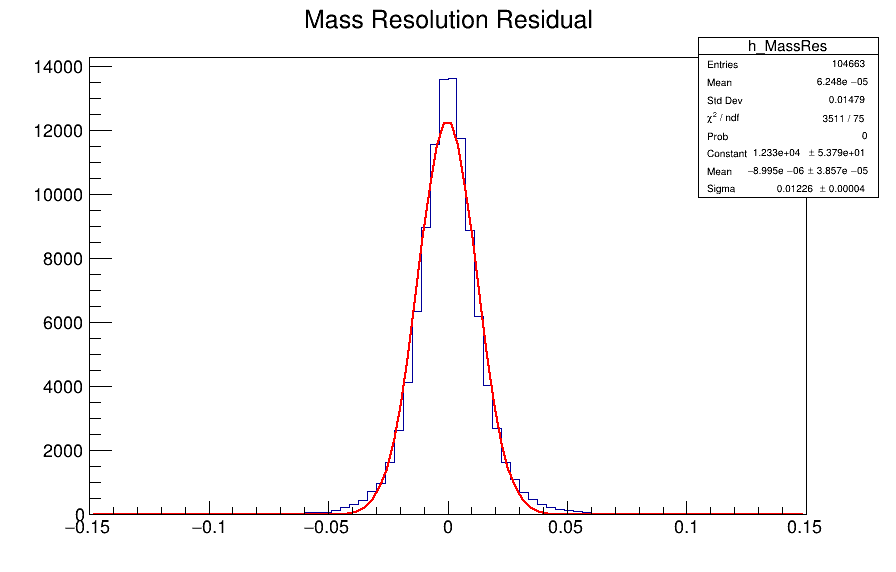

In [101]:
c17 = ROOT.TCanvas("massresidual","",900,600)
h_MassRes = ROOT.TH1F("h_MassRes","Mass Resolution Residual",80,-0.15,0.15)
for res in mass_res:
    h_MassRes.Fill(res)
h_MassRes.Draw()
c17.Draw()
h_MassRes.Fit("gaus")

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuEtavspTRes (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: muetavsptres


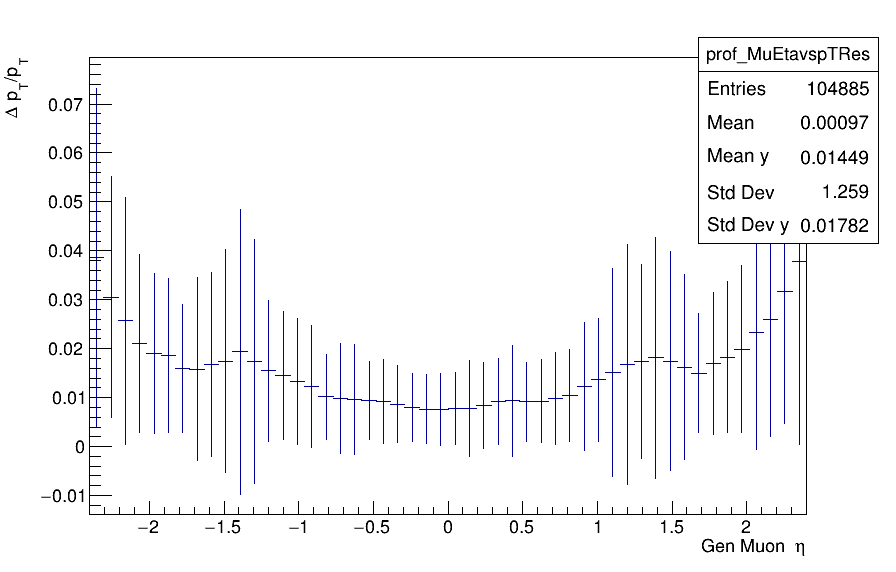

In [102]:
prof_MuEtavspTRes = ROOT.TProfile("prof_MuEtavspTRes",";Gen Muon #eta;#Delta p_{T}/p_{T}",50,-2.4,2.4,0,1,'s')
for ptres, eta in zip(pt_res, ak.flatten(two_opposite_good_muons.matched_gen.eta)):
    prof_MuEtavspTRes.Fill(eta, ptres, 1)
c18 = ROOT.TCanvas("muetavsptres","",900,600)
prof_MuEtavspTRes.Draw()
c18.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: prof_MupTvspTRes (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: muptvsptres


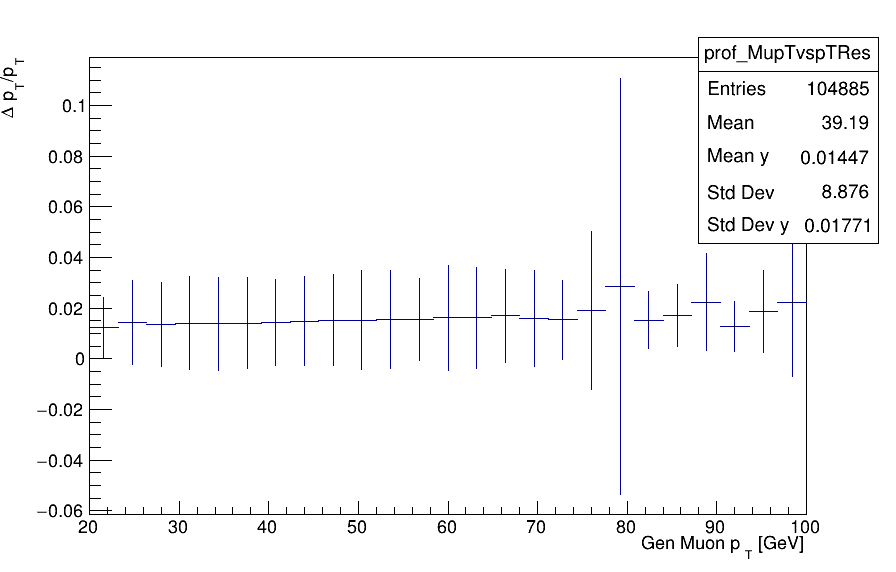

In [103]:
prof_MupTvspTRes = ROOT.TProfile("prof_MupTvspTRes",";Gen Muon p_{T} [GeV];#Delta p_{T}/p_{T}",25,20,100,0,1,'s')
for ptres, pt in zip(pt_res, ak.flatten(two_opposite_good_muons.matched_gen.pt)):
    prof_MupTvspTRes.Fill(pt, ptres, 1)
c19 = ROOT.TCanvas("muptvsptres","",900,600)
prof_MupTvspTRes.Draw()
c19.Draw()

**Questions 3:**
   * Describe the main differences that you observe between the uncorrected and corrected distributions. 
   * Does the corrected mass spectrum get closer to the generated mass spectrum, and the peak closer to the PDG value? 
   * How did the resolution change after the corrections? How would you explain it? 